In [2]:
import time
import matplotlib.pyplot as plt

from sast.utils_sast import *
from sast.sast import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

In [3]:
lab = False # True if I am on my lab computer
#ds_folder = '/home/mimbouop/ucr_dataset' if lab else '/home/michael/Projects/USTC/dataset/Shapelet_ucr'
ds_folder = r'C:\Users\Nicolas R\Documents\sast'
ds_name = 'Chinatown'
random_state = None

# Loading the dataset

In [4]:
train_ds, test_ds = load_dataset(ds_folder, ds_name)

X_train, y_train = format_dataset(train_ds, shuffle=True)
X_test, y_test = format_dataset(test_ds)

print(train_ds, y_train, end='\n\n')
print(test_ds, y_test)

     att1   att2   att3   att4   att5  att6  att7   att8   att9  att10  ...  \
0   573.0  375.0  301.0  212.0   55.0  34.0  25.0   33.0  113.0  143.0  ...   
1   394.0  264.0  140.0  144.0  104.0  28.0  28.0   25.0   70.0  153.0  ...   
2   603.0  348.0  176.0  177.0   47.0  30.0  40.0   42.0  101.0  180.0  ...   
3   428.0  309.0  199.0  117.0   82.0  43.0  24.0   64.0  152.0  183.0  ...   
4   372.0  310.0  203.0  133.0   65.0  39.0  27.0   36.0  107.0  139.0  ...   
5   448.0  344.0  183.0  146.0   71.0  14.0  30.0   41.0  108.0  137.0  ...   
6   621.0  322.0  221.0  150.0   65.0  40.0  42.0   84.0  148.0  190.0  ...   
7   597.0  409.0  142.0   93.0   48.0  30.0  34.0   87.0  132.0  157.0  ...   
8   525.0  431.0  248.0  240.0   91.0  64.0  29.0  117.0  200.0  236.0  ...   
9   587.0  382.0  165.0  192.0  130.0  44.0  21.0   35.0   73.0  132.0  ...   
10  144.0   73.0   21.0   16.0   10.0  12.0  26.0  100.0  177.0  220.0  ...   
11  141.0   63.0   51.0   14.0   16.0  14.0  28.0  1

## Plot some train instances

[1 2] 2


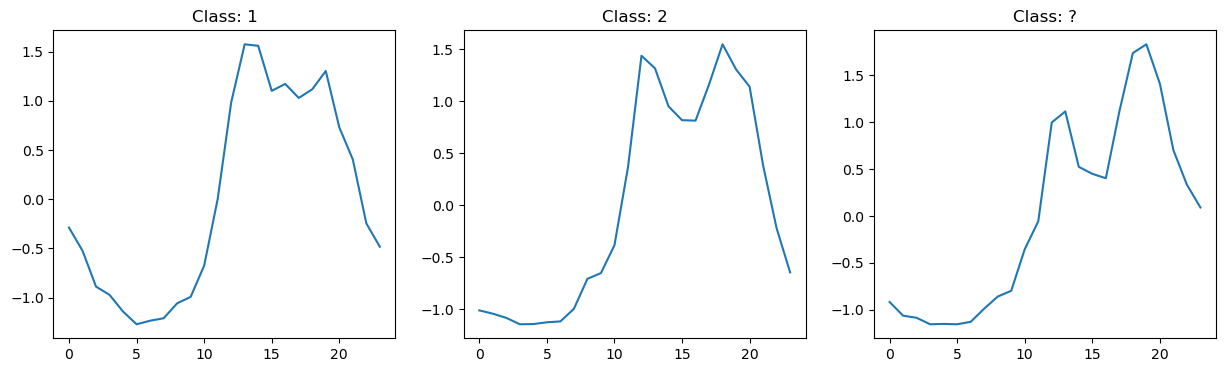

In [14]:
classes = np.unique(y_train)
count_per_classes = 1 # Number of instances to plot per each class
max_class_to_plot = min(3, len(classes)) # Number of classes to consider
plt.figure(figsize=(15, 4))
for i, c in enumerate(classes[:max_class_to_plot]):
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-one-instance-classification.jpg')

print(classes, max_class_to_plot)

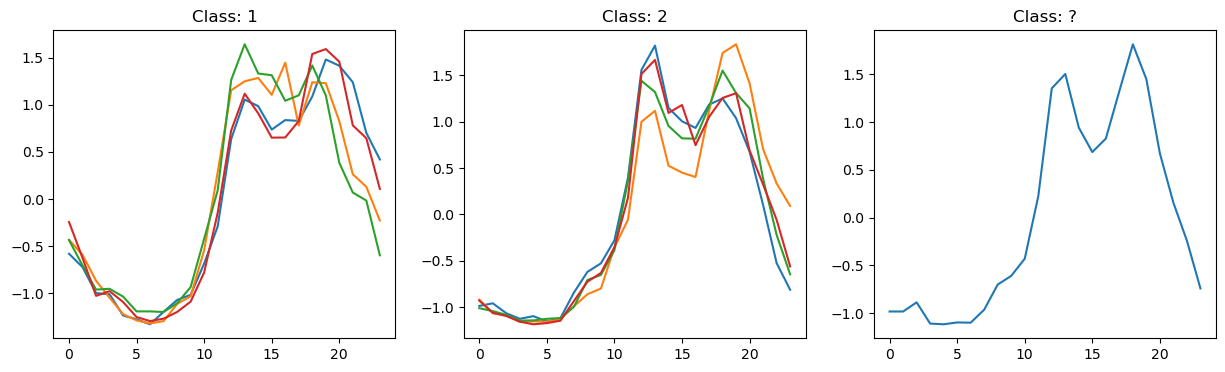

In [6]:
classes = np.unique(y_train)
count_per_classes = 4 # Number of instances to plot per each class
max_class_to_plot = min(3, len(classes)) # Number of classes to consider
plt.figure(figsize=(15, 4))
for i, c in enumerate(classes[:max_class_to_plot]):
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-multi-instance-classification.jpg')

# The SAST model

In [8]:
min_shp_length = 3
max_shp_length = X_train.shape[1]
candidate_lengths = np.arange(min_shp_length, max_shp_length+1)
# candidate_lengths = (3, 7, 9, 11)
nb_inst_per_class = 1

X_train.shape[1]

24

## SAST with RidgeClassifier

In [15]:
start = time.time()

ridge = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))

sast_ridge = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=ridge)
sast_ridge.fit(X_train, y_train)

print('score:', sast_ridge.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.9795918367346939
duration: 0.8397705554962158


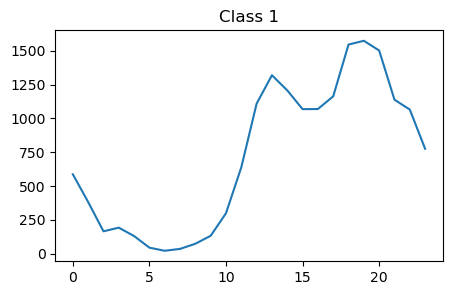

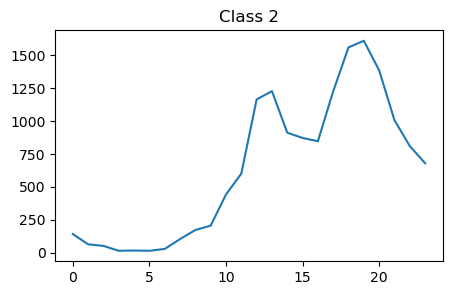

In [16]:
plot_kernel_generators(sast_ridge)

## Let's plot the top most important features over the generators

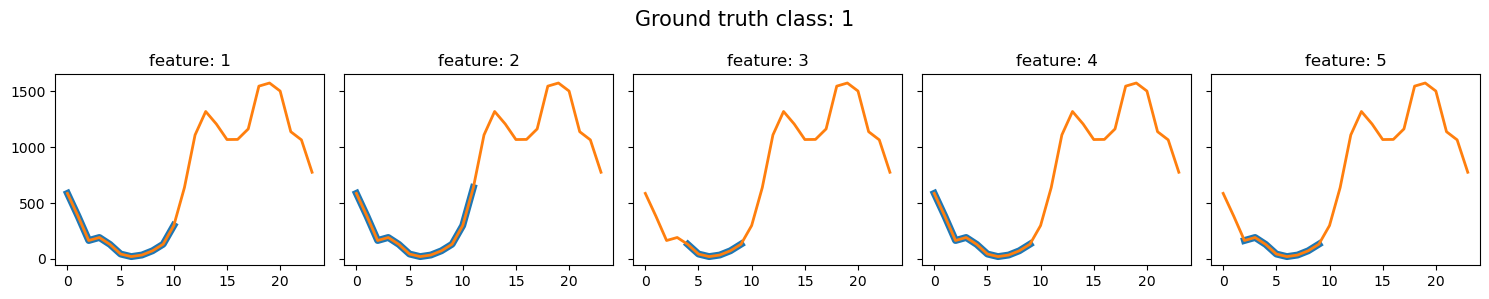

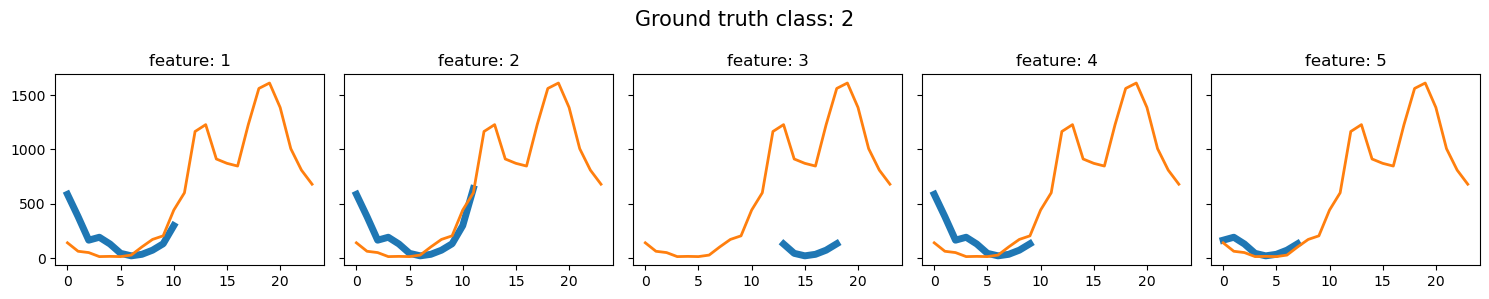

In [17]:
for c, ts in sast_ridge.kernels_generators_.items():
    fname = f'images/chinatown-ridge-class{c}-top5-features-on-ref-ts.jpg'
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=0, fname=fname) # plot only the first model one-vs-all model's features

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=5)

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=10)

## Let's plot the top best features on some test instances

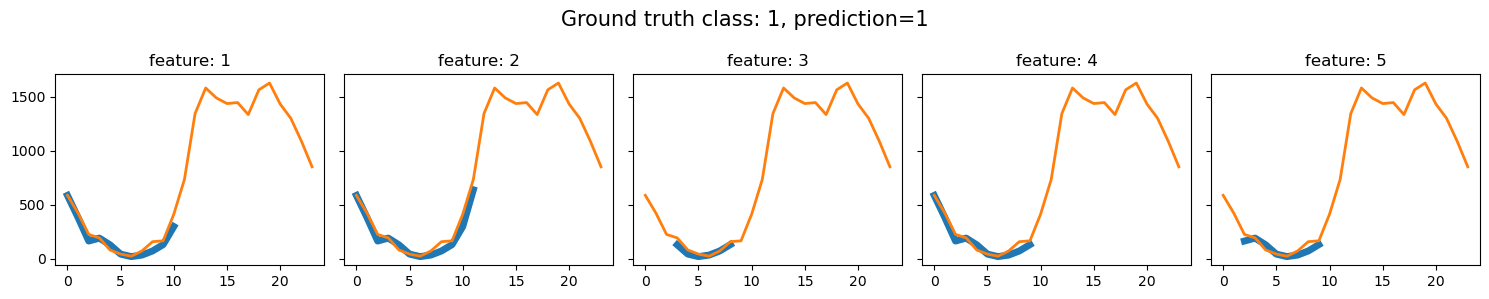

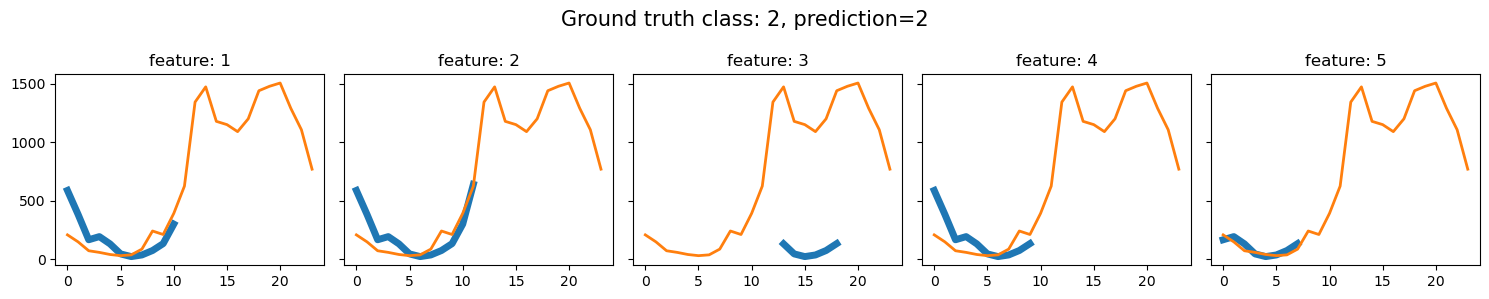

In [18]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_ridge.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-ridge-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], fname=fname) # plot only the first model one-vs-all model's features

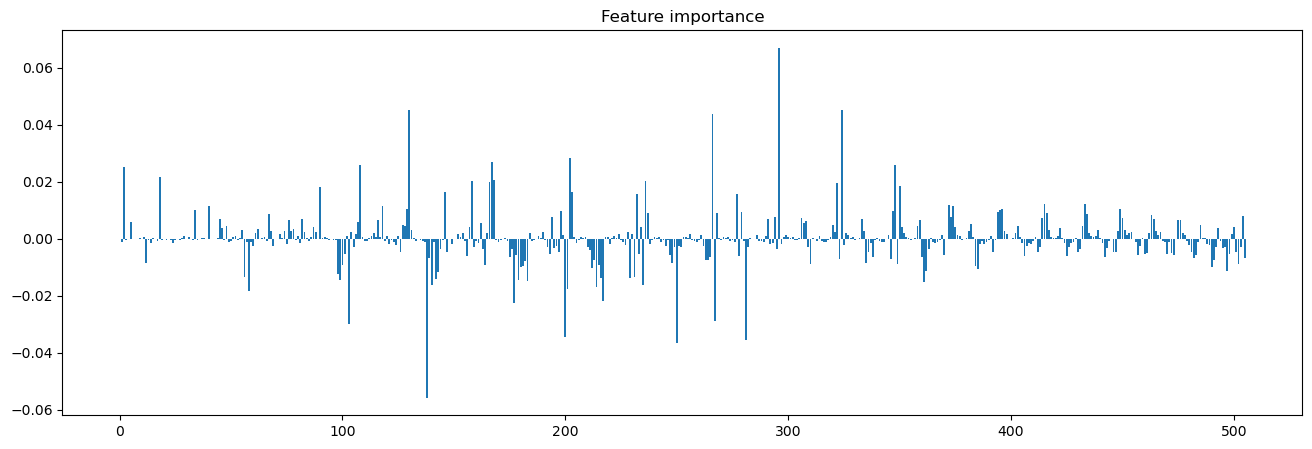

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_ridge.classifier.coef_[0].size)], sast_ridge.classifier.coef_[0]) # plot only the first model one-vs-all model's features
plt.show()
plt.savefig('images/chinatown-ridge-features-importance.jpg')

## SAST with RandomForest

In [20]:
start = time.time()

rf = RandomForestClassifier(max_features=None, min_impurity_decrease=0.05)

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=rf)
sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.9795918367346939
duration: 1.0634455680847168


## Let's plot the top most important features overs the generators

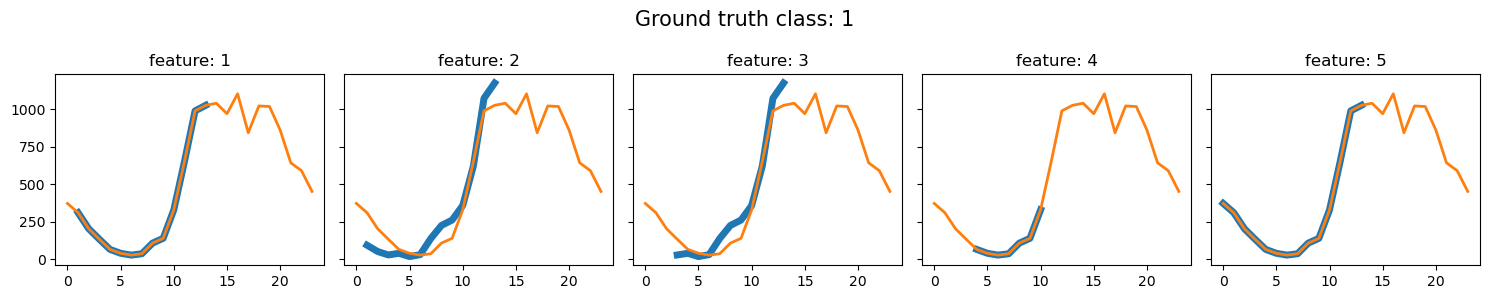

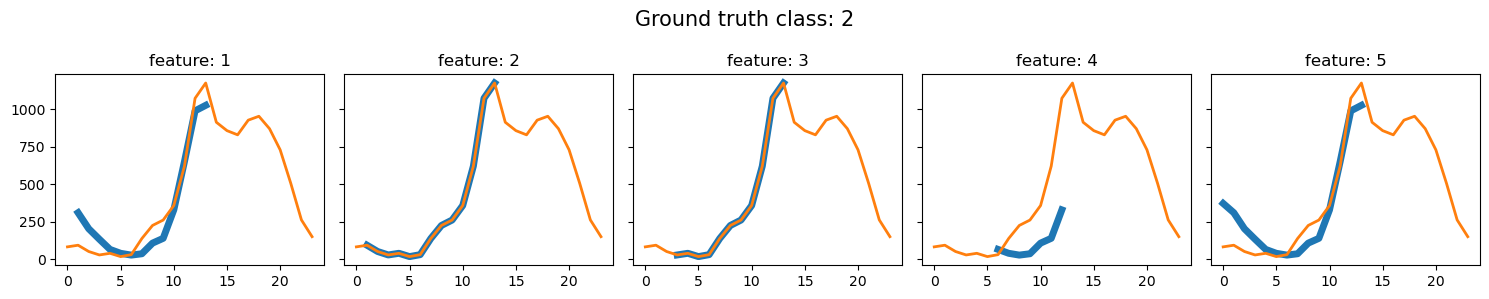

In [21]:
for c, ts in sast_rf.kernels_generators_.items():
    fname = f'images/chinatown-rf-class{c}-top5-features-on-ref-ts.jpg'
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

## Plotting the top best features on some test instances

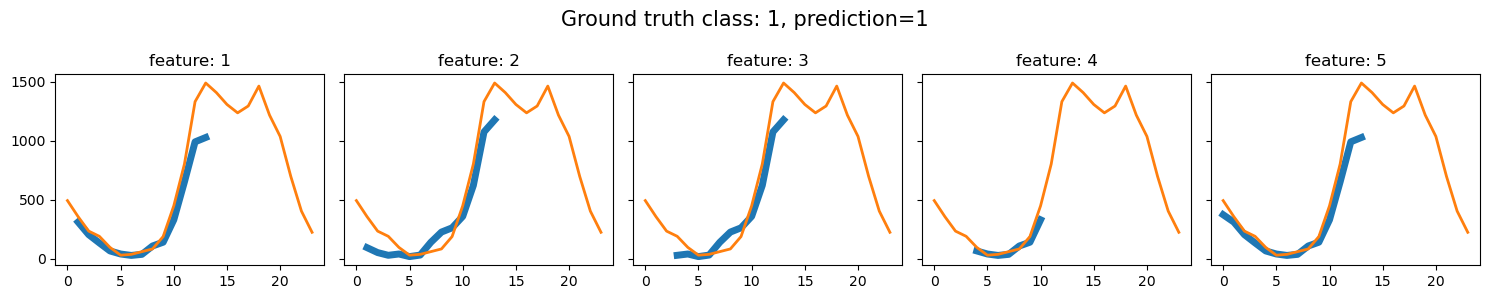

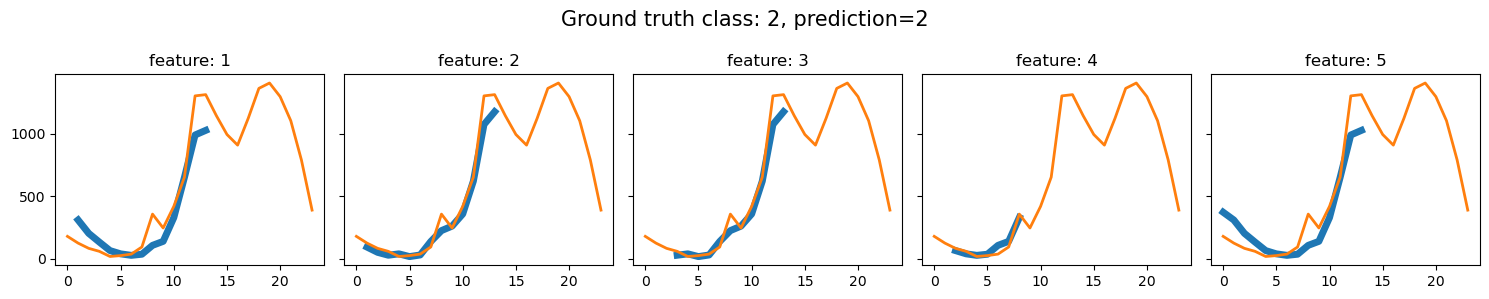

In [22]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_rf.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-rf-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

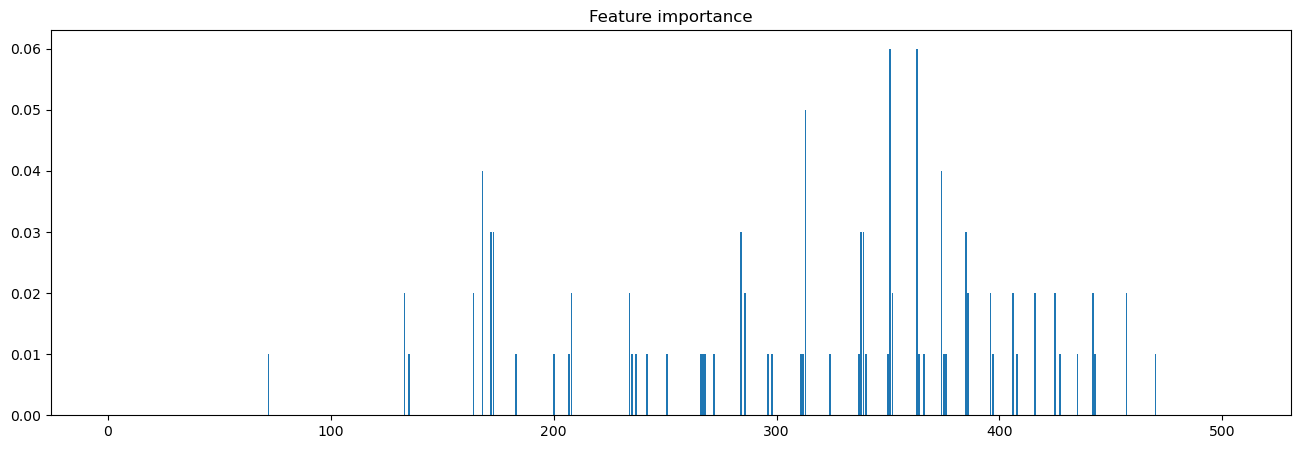

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_rf.classifier.feature_importances_.size)], sast_rf.classifier.feature_importances_)
plt.show()
plt.savefig('images/chinatown-rf-features-importance.jpg')

# Ensemble of weak SAST   

A weak SAST model is a SAST model that uses fixed length subsequences. It is faster dans a regular SAST model, could be less accurate

In [24]:
candidate_lengths = (3, 5, 7)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf)

start = time.time()

sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.8454810495626822
duration: 0.2825922966003418


In [25]:
candidate_length_list = [list(range(3, 10)), list(range(10, 17)), list(range(17, 24))]
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf = RandomForestClassifier(min_impurity_decrease=0.05, max_features=None)
saste = SASTEnsemble(cand_length_list=candidate_length_list,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf, n_jobs = -1)

start = time.time()

saste.fit(X_train, y_train)

print('Score:', saste.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

Score: 0.9591836734693877
duration: 13.490210056304932


In [26]:
saste

SASTEnsemble(cand_length_list=[[3, 4, 5, 6, 7, 8, 9],
                               [10, 11, 12, 13, 14, 15, 16],
                               [17, 18, 19, 20, 21, 22, 23]],
             classifier=RandomForestClassifier(max_features=None,
                                               min_impurity_decrease=0.05),
             n_jobs=-1)

### GridSearch of weights

In [27]:
candidate_length_list

[[3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22, 23]]

In [28]:
from itertools import combinations

weights = np.linspace(0, 1, len(candidate_length_list))
weights

array([0. , 0.5, 1. ])

In [29]:
from sklearn.model_selection import GridSearchCV

#params = {'weights': [(0.5, 0.5), (0.3, 0.7), (0.7, 0.3)]}
params = {'weights': [(0.5, 0.5), (0.3, 0.7), (0.7, 0.3), (0.7, 0.3)]}
saste_grid = GridSearchCV(estimator=saste, param_grid=params, cv=4, n_jobs = -1)

start = time.time()

saste_grid.fit(X_train, y_train)

print('Score:', saste_grid.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

ValueError: Number of `estimators` and weights must be equal; got 2 weights, 3 estimators

# Using Shapelet Transform

In [32]:
from sktime.utils.data_container import detabularise
from sktime.transformers.series_as_features.shapelets import ShapeletTransform

ModuleNotFoundError: No module named 'sktime.utils.data_container'

In [43]:
def plot_shapelets(st, X_train, y_train, nb_shapelet = np.inf, offset = 0, fname=None):
    shapelet_per_time_series = {}
    max_ = min(len(st.shapelets), nb_shapelet)
    for i in range(offset, max_ + offset):
        s = st.shapelets[i]
        # summary info about the shapelet
        print("#"+str(i)+": "+str(s))
        if s.series_id in shapelet_per_time_series:
            shapelet_per_time_series[s.series_id].append(s)
        else:
            shapelet_per_time_series[s.series_id] = [s,]
    
    max_ = len(shapelet_per_time_series)
    fig, axes = plt.subplots(1, max_, figsize= (3*max_, 3), tight_layout=True)
    for i, ts_id in enumerate(shapelet_per_time_series.keys()):
        ts_normalized = znormalize_array(X_train.iloc[ts_id,0].values)
        for j, s in enumerate(shapelet_per_time_series[ts_id]):
            # overlay shapelets
            axes[i].plot(
                list(range(s.start_pos,(s.start_pos+s.length))),
                ts_normalized[s.start_pos:s.start_pos+s.length],
                linewidth=5
            )
        axes[i].plot(ts_normalized)
        axes[i].set_title(f'Time series: {ts_id}, class: {y_train[ts_id]}')
    if fname is not None:
        plt.savefig(fname=fname)
    plt.show()

In [27]:
# convert our dataset to sktime format
X_train_sktime = detabularise(pd.DataFrame(X_train))
X_test_sktime = detabularise(pd.DataFrame(X_test))

## ST

In [28]:
start = time.time()

st = ShapeletTransform(min_shapelet_length=min_shp_length, max_shapelet_length=np.inf)
st.fit(X_train_sktime, y_train)

X_train_transformed = st.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = st.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test)) # Score: 0.9737609329446064 on Chinatown
print('Duration:', end - start)

Score: 0.9737609329446064
Duration: 51.488293170928955


#0: Series ID: 15, start_pos: 3, length: 9, info_gain: 0.9980008838722996, 
#1: Series ID: 0, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#2: Series ID: 5, start_pos: 0, length: 15, info_gain: 0.9980008838722996, 
#3: Series ID: 1, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#4: Series ID: 18, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 


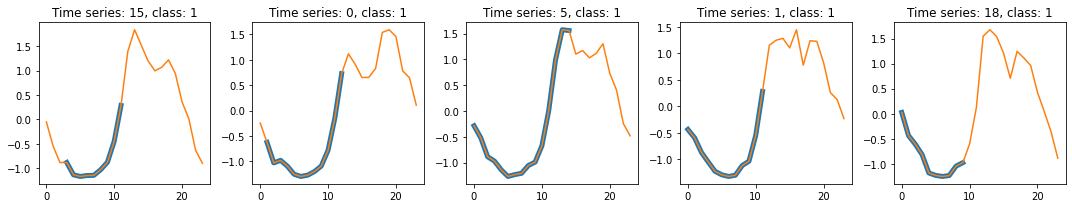

#5: Series ID: 13, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#6: Series ID: 8, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#7: Series ID: 17, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#8: Series ID: 16, start_pos: 1, length: 9, info_gain: 0.9980008838722996, 
#9: Series ID: 9, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 


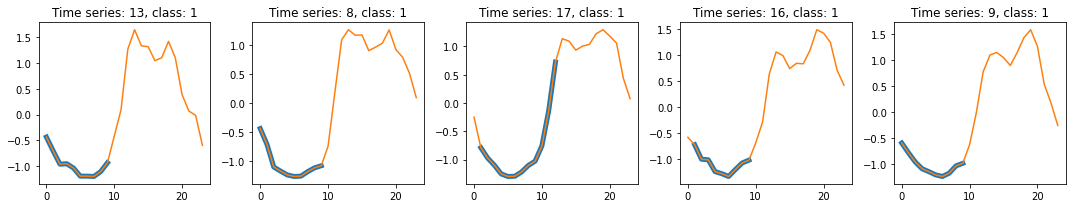

#10: Series ID: 11, start_pos: 2, length: 11, info_gain: 0.9980008838722996, 
#11: Series ID: 2, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#12: Series ID: 4, start_pos: 0, length: 17, info_gain: 0.9980008838722996, 
#13: Series ID: 3, start_pos: 0, length: 18, info_gain: 0.9980008838722996, 
#14: Series ID: 10, start_pos: 0, length: 18, info_gain: 0.9980008838722996, 


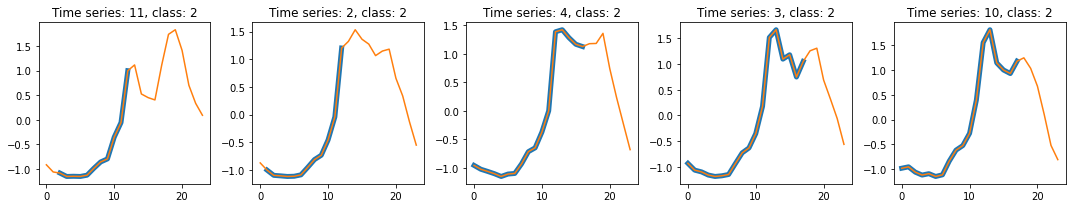

#15: Series ID: 12, start_pos: 3, length: 12, info_gain: 0.9980008838722996, 
#16: Series ID: 19, start_pos: 0, length: 13, info_gain: 0.9980008838722996, 
#17: Series ID: 14, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#18: Series ID: 7, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#19: Series ID: 6, start_pos: 0, length: 14, info_gain: 0.9980008838722996, 


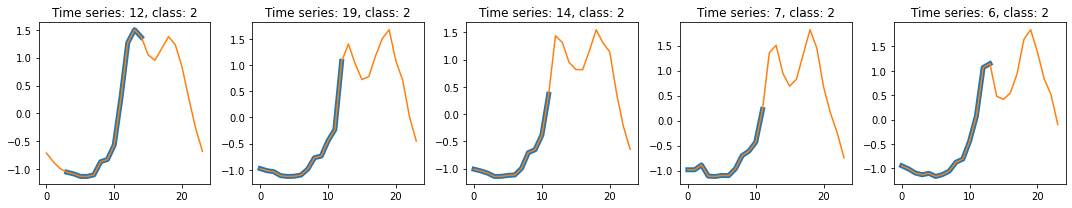

In [44]:
ncols = 5
for start in range(len(st.shapelets) // ncols):
    plot_shapelets(st, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname=f'images/chinatown-shapelets-{start}.jpg')

**Observation:** By using more than one instance by class, the model behaves like it is learning noisy versions of the same shaphelets

## OneShot ST

### OneShot ST 1:

Here, shapelets are selected using only the generators from KernelsGenerator  
The limitation of this approach is that the quality of a shapelet candidate is not computed on the whole training set, but only on the generators

In [22]:
# create the dataset to learn shapelet from
sast = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state)

sast.init_sast(X_train, y_train) 

y_resample = np.array(list(sast.kernels_generators_.keys()), dtype=np.int32)
X_resample = [t.squeeze() for _, t in sast.kernels_generators_.items()]
X_resample = np.array(X_resample, dtype=np.float32)
X_resample_sktime = detabularise(pd.DataFrame(X_resample))

start = time.time()

ost1 = ShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf)

ost1.fit(X_resample_sktime, y_resample)

X_train_transformed = ost1.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost1.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)

Score: 0.5160349854227405
duration: 0.48555922508239746


#0: Series ID: 0, start_pos: 0, length: 3, info_gain: 0, 
#1: Series ID: 1, start_pos: 0, length: 3, info_gain: 0, 


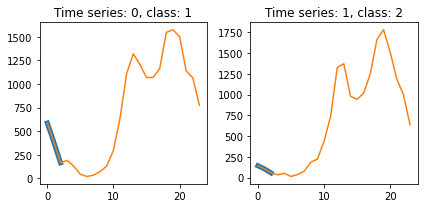

In [23]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    plot_shapelets(ost1, X_resample_sktime, y_resample, offset=start * ncols, nb_shapelet = ncols)

### OneShot ST 2:

Here we fix the limitation of the previous part by generating shapelet candidates from only `nb_inst_per_class` for each class, however the quality of each shapelet is computed over the whole training set

In [1]:
from stck import ShapeletTransformK

In [69]:
start = time.time()

ost2 = ShapeletTransformK(min_shapelet_length=min_shp_length, 
                          max_shapelet_length=np.inf, 
                          nb_inst_per_class=nb_inst_per_class)
ost2.fit(X_train_sktime, y_train)

X_train_transformed = ost2.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost2.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost2.nb_inst_per_class)

Score: 0.9708454810495627
duration: 6.0035200119018555
nb inst per class: 1


#0: Series ID: 9, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#1: Series ID: 3, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 


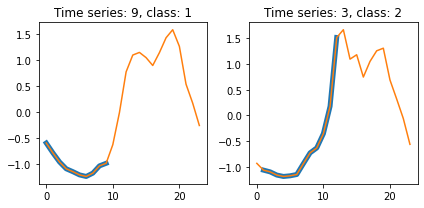

In [58]:
ncols = 5 if len(ost2.shapelets) > 5 else len(ost2.shapelets)
for start in range(len(ost2.shapelets) // ncols):
    plot_shapelets(ost2, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-1ST.jpg')

In [76]:
start = time.time()

ost3 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=2)
ost3.fit(X_train_sktime, y_train)

X_train_transformed = ost3.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost3.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost3.nb_inst_per_class)

Score: 0.9737609329446064
duration: 11.781237363815308
nb inst per class: 2


#0: Series ID: 18, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#1: Series ID: 15, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 
#2: Series ID: 7, start_pos: 3, length: 10, info_gain: 0.9980008838722996, 
#3: Series ID: 11, start_pos: 0, length: 13, info_gain: 0.9980008838722996, 


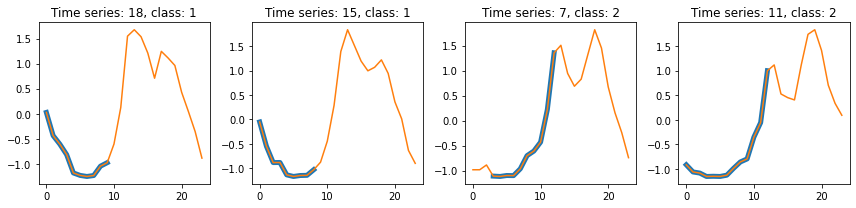

In [59]:
ncols = 5 if len(ost3.shapelets) > 5 else len(ost3.shapelets)
for start in range(len(ost3.shapelets) // ncols):
    plot_shapelets(ost3, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-2ST.jpg')

In [29]:
start = time.time()

ost4 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=3)
ost4.fit(X_train_sktime, y_train)

X_train_transformed = ost4.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost4.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost4.nb_inst_per_class)

Score: 0.967930029154519
duration: 17.7536883354187
nb inst per class: 3


#0: Series ID: 14, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#1: Series ID: 5, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 


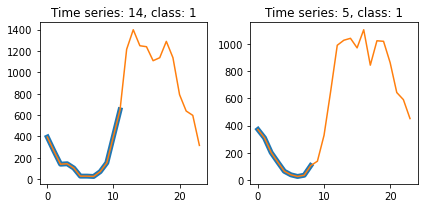

In [30]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    plot_shapelets(ost4, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols)